In [1]:
%load_ext autoreload
%autoreload 2
from hp import hp
from pathlib import Path
from fastai.data.all import get_files
import pandas as pd
import random, os, sys
from fastprogress import progress_bar, master_bar
import torch
import numpy as np

In [2]:
device = torch.device('cpu')

In [3]:
ds_root = Path(hp.data_root)
spk_folders = sorted(list((ds_root/'wav48_silence_trimmed').iterdir()))
print(f"[DATA] Found a total of {len(spk_folders)} speakers")

random.seed(hp.seed)
train_spk_folders = sorted(random.sample(spk_folders, k=hp.n_train_speakers))
test_spk_folders = sorted(list(set(spk_folders) - set(train_spk_folders)))
print(f"[DATA] Split into {len(train_spk_folders)} train speakers and {len(test_spk_folders)} test speakers")

[DATA] Found a total of 110 speakers
[DATA] Split into 100 train speakers and 10 test speakers


In [4]:
# Getting embeddings:
sse = torch.hub.load('RF5/simple-speaker-embedding', 'gru_embedder').to(device)
sse.eval()

Using cache found in /home/baas/.cache/torch/hub/RF5_simple-speaker-embedding_master


GRUEmbedder(
  (model): SpeakerEmbedderGRU(
    (rnn_stack): GRU(80, 768, num_layers=3, batch_first=True, dropout=0.3)
    (projection): Linear(in_features=768, out_features=256, bias=True)
  )
)

In [4]:
mb = master_bar(spk_folders)
out_path = Path(hp.speaker_embedding_dir)
os.makedirs(out_path, exist_ok=True)
spk_embs = {}
print("[SPEAKER EMBEDDING] Gathering speaker embeddings")
for spk_folder in mb:
    
    random.seed(50)
    sample_uttrs = random.sample(list(spk_folder.iterdir()), k=hp.n_uttr_per_spk_embedding)
    embs = []
    if (out_path/f"{spk_folder.stem}_sse_emb.pt").is_file(): 
        spk_embs[spk_folder.stem] = torch.load(Path('sse_embeddings')/f"{spk_folder.stem}_sse_emb.pt")
        continue

    for i, uttr_pth in progress_bar(enumerate(sample_uttrs), total=len(sample_uttrs), parent=mb):
        mb.child.comment = f"processing speaker {spk_folder.stem} ({i} of {len(sample_uttrs)})"
        mel = sse.melspec_from_file(uttr_pth).to(device)
        with torch.no_grad():
            embedding = sse(mel[None])[0]
        embs.append(embedding.cpu())
    
    emb = torch.stack(embs, dim=0)
    emb = emb.mean(dim=0)
    spk_embs[spk_folder.stem] = emb
    torch.save(emb, out_path/f"{spk_folder.stem}_sse_emb.pt")

[SPEAKER EMBEDDING] Gathering speaker embeddings


In [6]:
del sse
torch.cuda.empty_cache()

In [5]:
# Training:
train_files = []
for pth in train_spk_folders: train_files.extend(list(pth.iterdir()))
test_files = []
for pth in test_spk_folders: test_files.extend(list(pth.iterdir()))
len(train_files), len(test_files)

(80238, 8090)

In [6]:
from spec_utils import get_mspec
import matplotlib.pylab as plt
from data import get_loader
import librosa.display
from model_vc import Generator
import torch.nn.functional as F

mspec = get_mspec(train_files[0], True)
mspec.max(), mspec.min()

(tensor(0.6570), tensor(-11.5129))

(tensor(1.0771), tensor(0.0406), torch.Size([1, 128, 80]))

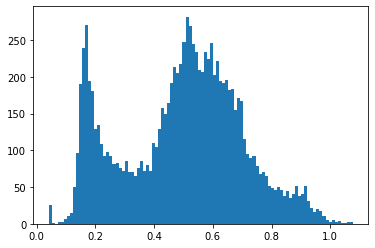

In [19]:
tdl = get_loader(train_files, spk_embs, 128, shift=12, scale=12, shuffle=False, batch_size=1)
# i, (spec, embs) = next(enumerate(tdl))
spec, embs = tdl.dataset[10]
embs = embs[None]; spec = spec[None]
_ = plt.hist(spec.numpy().flatten(), bins=100)
spec.max(), spec.min(), spec.shape

In [8]:
def showspec(spec):
    if type(spec) == torch.Tensor: spec = spec.cpu().squeeze().numpy()
    if spec.shape[-1] == 80: spec = spec.T
    librosa.display.specshow(spec, sr=16000, cmap='viridis', hop_length=256, x_axis='time')
    plt.tight_layout()
    plt.show()

In [9]:
G = Generator(32, 256, 512, 32).to(device)
checkpoint = torch.load('outputs/run3/checkpoint_last.pth', map_location=device)
G.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint.keys())

dict_keys(['epoch', 'iter', 'model_state_dict', 'opt_state_dict', 'loss'])


MSE reconstruction error: 0.00642
L2 norm of reconstruction error: 8.10954


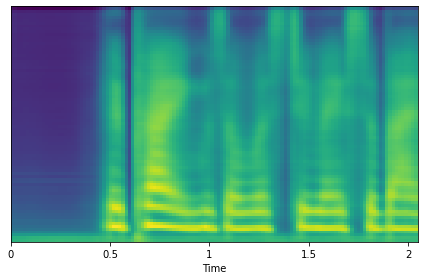

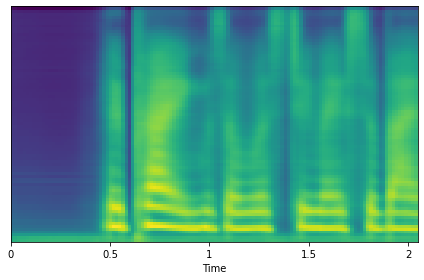

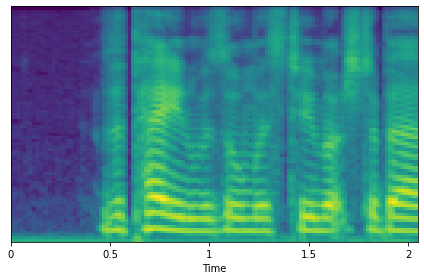

In [22]:
with torch.no_grad():
    x_src = spec.clone()
    s_src = embs.clone()
    x_identic, x_identic_psnt, _ = G(x_src, s_src, s_src)
print(f"MSE reconstruction error: {F.mse_loss(x_identic_psnt.squeeze(), x_src.squeeze()):6.5f}")
reconstr_err = (x_identic_psnt[0, 0] - x_src[0])
print(f"L2 norm of reconstruction error: {torch.norm(reconstr_err, p=2):6.5f}")
showspec(x_identic_psnt); showspec(x_identic); showspec(x_src)

In [117]:
from hifigan.models import Generator as HiFiGenerator
from hifigan.env import AttrDict
import json
import soundfile as sf
import IPython.display as ipd

In [111]:
# ckpt = torch.load('hifigan/checkpoints/UNIVERSAL_V1/g_02500000', map_location=device)
ckpt = torch.load('../../hifigan_checkpoints/g_03295000.pth', map_location=device)
config_file = Path('hifigan/checkpoints/UNIVERSAL_V1/config.json')
with open(config_file) as f: data = f.read()
json_config = json.loads(data)
h = AttrDict(json_config)
vocoder = HiFiGenerator(h).to(device)
vocoder.load_state_dict(ckpt['generator'])
vocoder.eval()
vocoder.remove_weight_norm()

Removing weight norm...


In [118]:
@torch.no_grad()
def vocode(spec):
    _m = tdl.dataset.denorm_mel(spec).T[None]
    print(_m.shape)
    waveform = vocoder(_m.to(device))[0]
    ipd.display(ipd.Audio(data=waveform.cpu().numpy(), rate=22050))
    plt.plot(waveform.cpu().squeeze().numpy())
    return waveform.squeeze()

torch.Size([1, 80, 128])


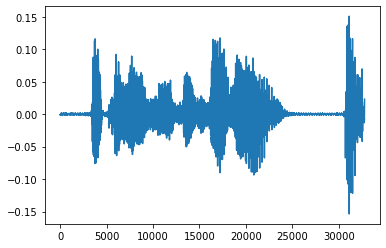

In [120]:
waveform = vocode(x_identic_psnt[0, 0])

In [121]:
sf.write('tmp2.wav', waveform, 16000)

In [36]:
p = [(f.name, len(list(f.iterdir()))) for f in train_spk_folders][:40]

In [37]:
sum([s[1] for s in p])

31960

In [31]:
batches_per_epoch = 31960//2

In [33]:
100000/batches_per_epoch

6.257822277847309

In [38]:
batches_per_epoch*2000

31960000